In [28]:
# Import Libraries
import math
import requests
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from time import sleep
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"


from nsepy import get_history
import datetime

import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Finance Libs
# from pandas_datareader import data # Not working
import yfinance as yf
from yahoofinancials import YahooFinancials
import googlefinance as gf
# from nsepy import get_history # Not working
import nselib
import datetime as dt
import ta

In [32]:
# Default Plotly attrs
import plotly.io as pio

# Define your default template
default_template = pio.templates["simple_white"]

# Update spike attributes
default_template.layout.xaxis.showspikes = True
default_template.layout.xaxis.showgrid = True
default_template.layout.yaxis.showgrid = True
default_template.layout.xaxis.gridwidth = 0.4
default_template.layout.yaxis.gridwidth = 0.4
default_template.layout.xaxis.spikethickness = 1  # all points
default_template.layout.xaxis.spikemode = 'across'  # show spike line for other axis

# Set the default template
pio.templates.default = "simple_white"

## Data

In [3]:
tckrs = ["SBIN.NS", "GOLDBEES.NS", "VBL.NS"]

returns_df = pd.DataFrame()
for tckr in tckrs:
    data = yf.download(tckr, start="2023-08-31", end="2024-09-01")

    # Calculate daily returns
    data['Daily Return'] = 100 * data['Adj Close'].pct_change()
    data.dropna(inplace=True)
    returns_df[tckr.split(".")[0]] = data['Daily Return']
    
# returns_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: >

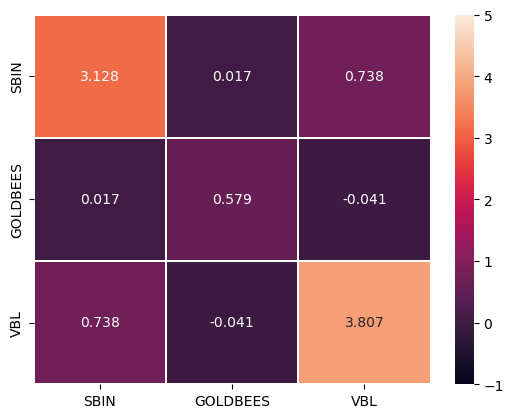

In [28]:
# variance covariance of returns
sns.heatmap(returns_df.cov(), annot=True, vmin=-1, vmax=5,
            linewidth=.2, fmt=".3f")

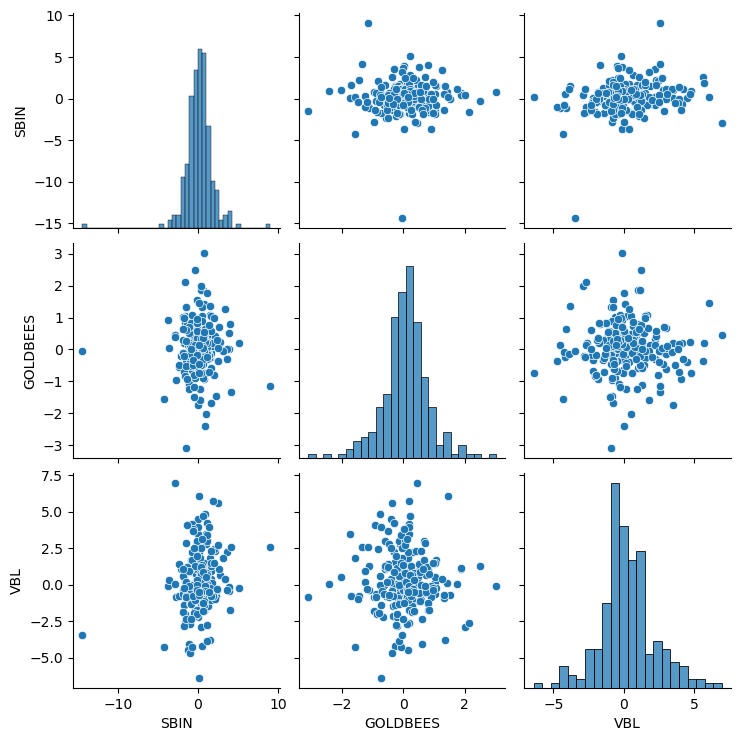

In [29]:
sns.pairplot(returns_df)

## Maths

<font size="4">

$R = w_1 R_1 + w_2 R_2 + w_3 R_3$

The expected return for our portfolio will then be:

$
E(R) = w_1 r_1 + w_2 r_2 + w_3 r_3 = \bar{r}^T \bar{w} = \bar{w}^T \bar{r}
$

The variance for our portfolio will then be:

$
Var(R) = Var(w_1 R_1 + w_2 R_2 + w_3 R_3)
$

$
= \sum_{i,j} Cov(w_i R_i, w_j R_j)
$

$
= \sum_{i,j} w_i w_j Cov(R_i, R_j)
$

$
= w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + w_3^2 \sigma_3^2 + 2 w_1 w_2 \sigma_{12} + 2 w_1 w_3 \sigma_{13} + 2 w_2 w_3 \sigma_{23}
$

$
= \bar{w}^T \Sigma \bar{w}
$


<font size="4">

Suppose now we wish to invest our portfolio by specifying a desired return and then minimizing the variance. The only change that occurs is that we gain a new condition.

Now we wish to choose $(w_1, w_2, w_3)$ which minimizes:

$$
Var(R) = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + w_3^2 \sigma_3^2 + 2 w_1 w_2 \sigma_{12}^2 + 2 w_1 w_3 \sigma_{13}^2 + 2 w_2 w_3 \sigma_{23}^2
$$

subject to the two constraints:

$$
w_1 + w_2 + w_3 = 1 \\
E(R) = r_1 w_1 + r_2 w_2 + r_3 w_3 = r_0 \\
$$

where $r_0$ is the desired return.

We define the Lagrange function:

$$
L = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + w_3^2 \sigma_3^2 + 2 w_1 w_2 \sigma_{12}^2 + 2 w_1 w_3 \sigma_{13}^2 + 2 w_2 w_3 \sigma_{23}^2
+ \lambda_1 (w_1 r_1 + w_2 r_2 + w_3 r_3 - r_0) + \lambda_2 (w_1 + w_2 + w_3 - 1)
$$

and solve the system $\nabla L = 0$ which is: <br><br><br>
$$
2\sigma_1^2 w_1 + 2\sigma_{12}^2 w_2 + 2\sigma_{13}^2 w_3 + r_1 \lambda_1 + \lambda_2 = 0 \\
2 \sigma_{12}^2 w_1 + 2 \sigma_2^2 w_2 + 2 \sigma_{23}^2 w_3 + r_2 \lambda_1 + \lambda_2 = 0 \\
2 \sigma_{13}^2 w_1 + 2 \sigma_{23}^2 w_2 + 2 \sigma_3^2 w_3 + r_3 \lambda_1 + \lambda_2 = 0 \\
r_1 w_1 + r_2 w_2 + r_3 w_3 - r_0 = 0 \\
w_1 + w_2 + w_3 - 1 = 0
$$
<br><br>
    
Notice that this can be rewritten as a matrix equation:

$$
\begin{bmatrix}
2\sigma_1^2 & 2\sigma_{12}^2 & 2\sigma_{13}^2 & r_1 & 1 \\
2\sigma_{12}^2 & 2\sigma_2^2 & 2\sigma_{23}^2 & r_2 & 1 \\
2\sigma_{13}^2 & 2\sigma_{23}^2 & 2\sigma_3^2 & r_3 & 1 \\
r_1 & r_2 & r_3 & 0 & 0 \\
1 & 1 & 1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
w_1 \\
w_2 \\
w_3 \\
\lambda_1 \\
\lambda_2
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0 \\
0 \\
r_0 \\
1
\end{bmatrix}
$$

which can be rewritten much more simply using the covariance matrix as:

$$
\begin{bmatrix}
2\Sigma & \bar{r} & \bar{1} \\
\bar{r}^T & 0 & 0 \\
\bar{1}^T & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\bar{w} \\
\lambda_1 \\
\lambda_2
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} \\
r_0 \\
1
\end{bmatrix}
$$

which is again especially nice since it generalizes to more than three options and can be solved via a matrix inverse:

$$
\begin{bmatrix}
\bar{w} \\
\lambda_1 \\
\lambda_2
\end{bmatrix}
=
\begin{bmatrix}
2\Sigma & \bar{r} & \bar{1} \\
\bar{r}^T & 0 & 0 \\
\bar{1}^T & 0 & 0
\end{bmatrix}^{-1}
\begin{bmatrix}
\bar{0} \\
r_0 \\
1
\end{bmatrix}
$$


## Code

In [4]:
r0 = 0.18  # Expected return from our portfolio

In [21]:
# Find optimal weights
def find_optimal_weights(r0, returns_df):
    r = returns_df.mean(axis=0).values \
                  .reshape(-1, 1) # returns as column vector

    sigma = returns_df.cov().values # cov matrix Σ

    n = len(r)
    m = n + 2
    A = np.zeros((m,m))
    A[:n, :n] = 2 * sigma

    A[:n, n] = r.squeeze()
    A[n, :n] = r.squeeze()
    A[:n, m-1] = 1
    A[m-1, :n] = 1

    b = np.vstack((np.zeros_like(r), np.array([[r0], 
                                               [1]])))
    # solve for x: Ax = b
    x = np.linalg.inv(A) @ b
    w_opt = x[:3]
    # min variance for return r0
    std_opt = np.sqrt((w_opt.T @ sigma @ w_opt)[0, 0])
    
    return np.squeeze(w_opt), std_opt

In [22]:
w_opt, std_opt = find_optimal_weights(r0, returns_df)
w_opt, std_opt

(array([0.30821906, 0.22770201, 0.46407893]), 1.1627246621302658)

## Risk Vs Return - Efficient Frontier

In [119]:
# risk free return
rf = 0.02  # (1 + 0.00015)**365 = 1.056 So 5.6 % CAGR

def calc_sharpe_ratio(rp, sp, rf):
    '''rp, sp - return and std of the portfolio
       rf - risk free return
    '''
    return (rp - rf)/sp

def calc_return_from_sharpe_ratio(sr, sp, rf):
    '''
    sr - sharpe ratio
    sp - std of the portfolio
    rf - risk free return
    '''
    rp = (sr * sp) + rf
    return rp

return_list = []
risk_list = []
sharpe_ratio_list = []

for r0 in np.arange(0.05, 0.25, 0.004):
    w_opt, std_opt = find_optimal_weights(r0, returns_df)
    
    risk_list.append(std_opt)    
    return_list.append(r0)
    sharpe_ratio_list.append(calc_sharpe_ratio(r0, std_opt, rf))

In [123]:
sharpe_rat = 0.15

std_ls = np.arange(0, max(risk_list), 0.1)
r_sharpe_ls = calc_return_from_sharpe_ratio(sharpe_rat, std_ls, rf)

In [131]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=risk_list, y=return_list, text = sharpe_ratio_list,
               marker_color = sharpe_ratio_list,
               hovertemplate = \
                   "<b>std</b>: %{x:.3f}<br><b>return</b>: %{y:.3f}<br>" +\
                   "<b>sharpe ratio</b>:  %{text:.3f}<br>",
               mode="lines+markers", name="Efficient<br>Frontier")
)

fig.add_trace(go.Scatter(x=std_ls, y=r_sharpe_ls, mode="lines", 
                         line=dict(dash="solid", width=1),
                         name=f"sharpe_ratio<br>{sharpe_rat}"))

fig.update_xaxes(rangemode="tozero", title="Risk")
fig.update_yaxes(rangemode="tozero", title="Return")
fig.show()

In [58]:
x = np.linalg.inv(A) @ b
x

array([[  0.30821906],
       [  0.22770201],
       [  0.46407893],
       [-24.57469524],
       [  1.71958786]])

In [60]:
np.round(A @ x, 7)

array([[ 0.  ],
       [-0.  ],
       [-0.  ],
       [ 0.18],
       [ 1.  ]])

## Risk Vs. Return

(400, 200)

In [135]:
# Create a grid of points
w1 = np.linspace(0, 1, 200)
w2 = np.linspace(0, 1, 400)
W1, W2 = np.meshgrid(w1, w2)
W3 = 1 - W1 - W2

sigma = returns_df.cov().values # cov matrix Σ

def calc_var(w1, w2, w3, sigma):
    
    return w1**2*sigma[0,0] + w2**2*sigma[1,1] + w3**2* sigma[2,2] + \
            2*(w1*w2)*sigma[0,1] + 2*(w2*w3)*sigma[1,2] + 2*(w1*w3)*sigma[1,2]

variance = calc_var(W1, W2, W3, sigma)

<a list of 16 text.Text objects>

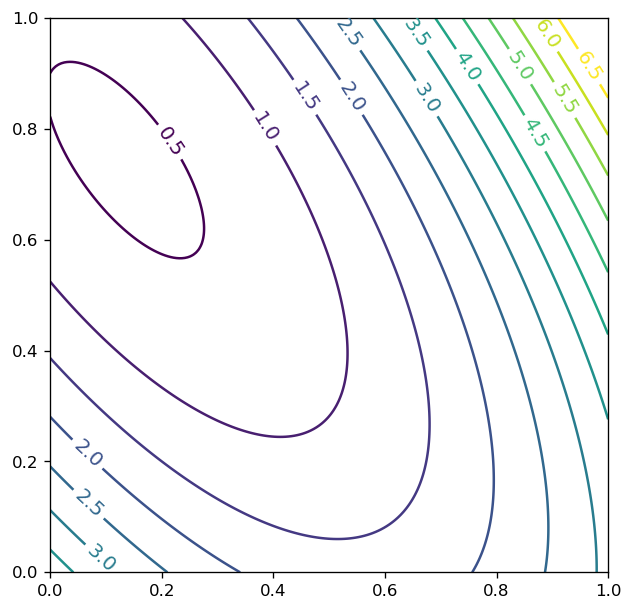

In [143]:
# Create a contour plot
plt.figure(figsize=(6, 6), dpi=120)
contour = plt.contour(W1, W2, variance, 
                      levels=np.arange(0.5, 7, 0.5), cmap='viridis', lw=0.1) 
plt.clabel(contour, inline=True, fontsize=12)  # label the contours